<a href="https://colab.research.google.com/github/SultanDaffaN/portfolio-sultan/blob/main/Tweets%20about%20Flood%20in%20Indonesia/Tweets_about_Flood_in_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
# Manipulating Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Natural Language Tool Kit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Pytorch and IndoBERT
import torch
from torch import optim
import torch.nn.functional as F

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer
from torch.utils.data import Dataset, DataLoader

# Others
import time
import re
import random
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Reading Dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
local_path = '/content/drive/MyDrive/Portfolio/Tweets about Flood in Indonesia/'

In [92]:
train = pd.read_csv(f'{local_path}/train.csv')
test = pd.read_csv(f'{local_path}/test.csv')

In [93]:
train.head()

,created_at,id,user_id,user_name,url,text,media,label
0,2020-02-23 04:06:39+00:00,1231430140824973313,133931409,r0b1 sur1a (黄玉春),https://twitter.com/R0b1Sur1a/status/123143014...,Akhirnya sampai juga setelah menerobos banjir....,ERbrKgFU4AAnADb.jpg,0
1,2020-01-05 01:46:46+00:00,1213637932411580417,253063316,Beradaptasi di Era Pandemi ☀️,https://twitter.com/MarikaRahman_/status/12136...,"Kemekes RI, IDI Banten, IBI Banten dan PPNI Ba...",ENe1HUVUEAANLFT.jpg,0
2,2020-01-18 06:22:09+00:00,1218418277946396673,64318803,rywyu,https://twitter.com/rywyu/status/1218418277946...,Dikarenakan cikini rada2 banjir tdi pagi hingg...,EOiw80RU0AcJ4CI.jpg,0
3,2020-02-22 23:38:00+00:00,1231362534717837313,17383917,ICALIZERS,https://twitter.com/icalizers/status/123136253...,#sperma TT dikala warga jakarta sedang prihati...,ERatrt9UYAAtLMI.jpg,0
4,2019-12-17 10:54:31+00:00,1206890412574568449,3102973556,AN,https://twitter.com/lokbin103/status/120689041...,"KUIS!\n\nJakarta banjir parah hari ini, pertan...",EL-8Z-vUcAIiIlV.jpg,0


In [94]:
test.head()

,created_at,id,user_id,user_name,url,text,media
0,2020-01-04 04:01:24+00:00,1213309429254250496,3278019654,Dinas LH Cakung,https://twitter.com/DinsihCakung/status/121330...,Giat pengangkutan sampah pasca banjir Rw 02 Ke...,ENaKfJ8VUAIUjb2.jpg
1,2020-01-12 03:14:24+00:00,1216196702647939072,1110443183379382272,Nunung Iskandar,https://twitter.com/IskandarNunung/status/1216...,Giat gotong-royong membersihkan jalan te kena ...,EODMcc8UEAA-7g_.jpg
2,2020-01-12 09:51:05+00:00,1216296533735309312,335900262,🇲🇾.N i e s a a .🇲🇾,https://twitter.com/Cik_AnaaNiesaa/status/1216...,"Terima kasih, tuan hamba. Tetap di sisi hamba ...",EOEnPtTUcAEsJXb.jpg
3,2020-03-02 07:48:31+00:00,1234385081482956800,3278019654,Dinas LH Cakung,https://twitter.com/DinsihCakung/status/123438...,pengambilan toilet portable tuntas pasca banji...,ESFqrKNU8AAip-t.jpg
4,2020-01-08 10:15:55+00:00,1214853229567041537,1186660471580921856,BEM STMIK WIDURI,https://twitter.com/bem_stmikwiduri/status/121...,[PRESS RELEASE]\nPra Kampus Widuri Peduli Benc...,ENwGelmUEAEa6Kq.jpg


In [95]:
testing_data = test[['id', 'text']]

# EDA

In [96]:
train['label'].value_counts()

0    1192
1     326
Name: label, dtype: int64

In [ ]:
print('Dataset size:',train.shape)
print('Columns are:',train.columns)

Dataset size: (1518, 8)
Columns are: Index(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media',
       'label'],
      dtype='object')


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  1518 non-null   object
 1   id          1518 non-null   int64 
 2   user_id     1518 non-null   int64 
 3   user_name   1518 non-null   object
 4   url         1518 non-null   object
 5   text        1518 non-null   object
 6   media       1518 non-null   object
 7   label       1518 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 95.0+ KB


Text(0, 0.5, '')

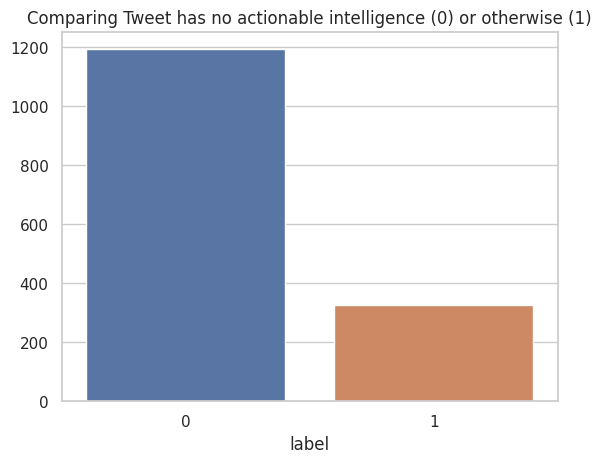

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x='label', data=train)
plt.title('Comparing Tweet has no actionable intelligence (0) or otherwise (1)')
plt.ylabel('')

In [ ]:
fig = px.pie(train, names='label', width=400, height=400)
fig.show()

# **Data Training**

## **Processing Text Data**

In [101]:
training_text = train[['id', 'text', 'label']]
training_text

,id,text,label
0,1231430140824973313,Akhirnya sampai juga setelah menerobos banjir....,0
1,1213637932411580417,"Kemekes RI, IDI Banten, IBI Banten dan PPNI Ba...",0
2,1218418277946396673,Dikarenakan cikini rada2 banjir tdi pagi hingg...,0
3,1231362534717837313,#sperma TT dikala warga jakarta sedang prihati...,0
4,1206890412574568449,"KUIS!\n\nJakarta banjir parah hari ini, pertan...",0
...,...,...,...
1513,1212485925860626434,Mohon doanya sahabat2ku untuk Musibah/ Bencana...,0
1514,1212604402969636869,Tidak perlu berdebat siapa yang salah... mau p...,0
1515,1242150538789019649,"Banjir, karena tidak ada resapan. \nMundur, k...",0
1516,1232074747707441152,"#banjir jam 05.45 diluar rumah 20-30 cm, didlm...",1


In [102]:
# print the text
training_text['text'].iloc[4]

'KUIS!\n\nJakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?\n\nA. Ahok\nB. Mentri PUPR\nC. Kadis\nD. Warga\n\nJawaban dikirimkan ke \n\nPO BOX 212\nDgn kode "ini bukan banjir tapi cobaan".\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas. https://t.co/SQED8TcW2b'

### **Removing the URl's**

In [ ]:
# Removing the last word
def remove_urls(texts):
  return re.sub('https?://\S+|www\.\S+', '', texts)

training_text['text'] = training_text['text'].apply(lambda x: remove_urls(x))

In [104]:
# print the text
training_text['text'].iloc[4]

'KUIS!\n\nJakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?\n\nA. Ahok\nB. Mentri PUPR\nC. Kadis\nD. Warga\n\nJawaban dikirimkan ke \n\nPO BOX 212\nDgn kode "ini bukan banjir tapi cobaan".\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas. '

### **Lower Casing**

In [ ]:
def lower_casing(text):
  return text.lower().strip()

training_text['text'] = training_text['text'].apply(lambda x: lower_casing(x))

In [106]:
# print the text
training_text['text'].iloc[4]

'kuis!\n\njakarta banjir parah hari ini, pertanyaannya, siapakah yg akan disalahkan gubernur kali ini?\n\na. ahok\nb. mentri pupr\nc. kadis\nd. warga\n\njawaban dikirimkan ke \n\npo box 212\ndgn kode "ini bukan banjir tapi cobaan".\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas.'

### **Remove Punctuation**

In [ ]:
import re
import string

PUNCTUATIONS = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))

training_text['text'] = training_text['text'].apply(lambda x: remove_punctuation(x))

In [108]:
# print the text
training_text['text'].iloc[4]

'kuis\n\njakarta banjir parah hari ini pertanyaannya siapakah yg akan disalahkan gubernur kali ini\n\na ahok\nb mentri pupr\nc kadis\nd warga\n\njawaban dikirimkan ke \n\npo box 212\ndgn kode ini bukan banjir tapi cobaan\n\n25 pemenang mendapatkan tiket gratis jalan2 di monas'

### **Extra Whitespaces**

In [ ]:
def remove_extra_whitespaces(text):
    return " ".join(text.split())

training_text['text'] = training_text['text'].apply(lambda x: remove_extra_whitespaces(x))

In [110]:
# print the text
training_text['text'].iloc[4]

'kuis jakarta banjir parah hari ini pertanyaannya siapakah yg akan disalahkan gubernur kali ini a ahok b mentri pupr c kadis d warga jawaban dikirimkan ke po box 212 dgn kode ini bukan banjir tapi cobaan 25 pemenang mendapatkan tiket gratis jalan2 di monas'

### **Remove Stopwords**

In [ ]:
from spacy.lang.id.stop_words import STOP_WORDS

def remove_stopwords(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.split()
    text = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(text)

    return text

training_text['text'] = training_text['text'].apply(lambda x: remove_stopwords(x))

In [112]:
# print the text
training_text['text'].iloc[4]

'kuis jakarta banjir parah pertanyaannya yg disalahkan gubernur kali a ahok b mentri pupr c kadis d warga dikirimkan po box dgn kode banjir cobaan pemenang tiket gratis jalan monas'

### **Word Counter**

In [ ]:
from collections import Counter

# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
counter = counter_word(training_text['text'])
print("There are %d unique words" % (len(counter)))

# show top 10 words
list(sorted(counter.items(), key=lambda x:x[1], reverse=True))[:10]

There are 7171 unique words


[('banjir', 1787),
 ('yg', 242),
 ('jakarta', 215),
 ('korban', 157),
 ('air', 143),
 ('rumah', 135),
 ('hujan', 119),
 ('warga', 114),
 ('bencana', 107),
 ('banjirjakarta', 104)]

In [ ]:
# Get the mean length of each sentences
length = np.mean([len(x) for x in training_text.text])
length

109.0171277997365

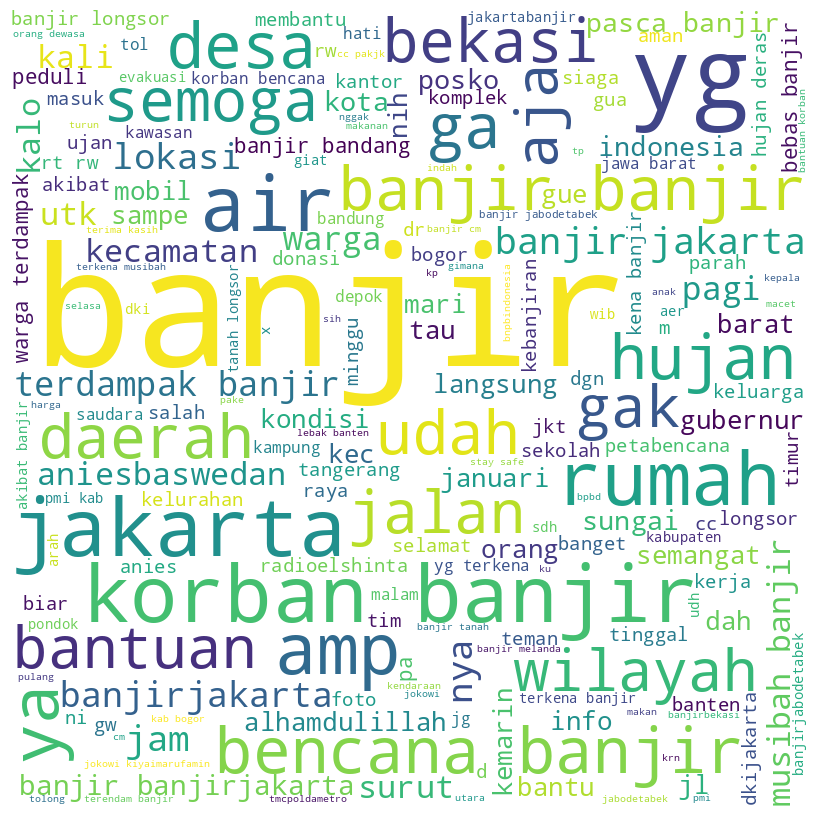

In [ ]:
# Word Cloud for Title
words = ''

# iterate through the csv file
for val in training_text['text']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## **Splitting Dataset**

In [113]:
# Stratified splitting (for testing & validation set)
labeled_0 = training_text.query(' label==0 ')
labeled_1 = training_text.query(' label==1 ')
print(labeled_0.shape)
print(labeled_1.shape)

(1192, 3)
(326, 3)


In [114]:
training_size = round(labeled_0.shape[0] * 80/100)
training_labeled_0 = labeled_0[0:training_size]
validation_labeled_0 = labeled_0[training_size:]

training_size = round(labeled_1.shape[0] * 80/100)
training_labeled_1 = labeled_1[0:training_size]
validation_labeled_1 = labeled_1[training_size:]

In [115]:
training_data = pd.concat([training_labeled_0, training_labeled_1])
training_data

,id,text,label
0,1231430140824973313,menerobos banjir,0
1,1213637932411580417,kemekes ri idi banten ibi banten ppni banten d...,0
2,1218418277946396673,cikini rada banjir tdi pagi gk tau udh surut k...,0
3,1231362534717837313,sperma tt dikala warga jakarta prihatin banjir...,0
4,1206890412574568449,kuis jakarta banjir parah pertanyaannya yg dis...,0
...,...,...,...
1197,1232107114841034753,banjir jalan kodamar bypass flyover kelapa gad...,1
1207,1212188311357255681,me semangat biarlah air banjir bantu,1
1208,1231576560320180225,kawasan menteng banjir tmc polda banjir cm jl ...,1
1212,1232189028616687616,first time bgt nih ngerasain namanya banjir ba...,1


In [116]:
validation_data = pd.concat([validation_labeled_0, validation_labeled_1])
validation_data

,id,text,label
1214,1213715102542680064,bpk menteri desa halimiskandarnu sdh meginstru...,0
1215,1217658100590604289,sebaran wilayah banjir petabencana dipakai bpp...,0
1216,1212220761005420545,katsoka korianka jalan tol bergelombang disala...,0
1217,1212687107086376960,yuk membantu korban banjir,0
1218,1218026615105437697,gara anies nih hello surabayapiye kabare semog...,0
...,...,...,...
1475,1213740456879640583,banjir,1
1490,1231385173440094209,banjir cm wilayah semper jakarta utara sindyanast,1
1503,1232075977385136128,berangkat kerja ujan banjir,1
1505,1232110804570296320,gerbang tol cempaka putih tidaka dilewati kend...,1


In [117]:
# Shuffling dataset
training_data = training_data.sample(frac=1).reset_index(drop=True)
validation_data = validation_data.sample(frac=1).reset_index(drop=True)
print(training_data.shape)
print(validation_data.shape)

(1215, 3)
(303, 3)


# **Build and Compile Model (LSTM)**

## **Tokenizing Texts**

In [ ]:
training_sentences = training_data.text
training_labels = training_data.label

validation_sentences = validation_data.text
validation_labels = validation_data.label

In [ ]:
# Setting the parameters use for embedding
vocab_size = len(counter)
max_length = 95
trunc_type='post'
padding_type='post'
oov_token = "<XXX>"
embedding_dim = 64
lstm_dim = 32

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

In [ ]:
print('training padded:', len(training_padded))
print('testing padded:', len(validation_padded))
print()
print('training labels:', len(training_labels))
print('validation labels:', len(validation_labels))

training padded: 1215
testing padded: 303

training labels: 1215
validation labels: 303


In [ ]:
# Create the LSTM model
text_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
text_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
text_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 64)            458944    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 490,082
Trainable params: 490,082
Non-trainable params: 0
__________________________________________________

## **Training the Model**

In [ ]:
# Setting the training parameters
NUM_EPOCHS = 30
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

In [ ]:
# Train the model
history = text_model.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels), callbacks=[earlystopping])

Epoch 1/30
38/38 [==============================] - 20s 274ms/step - loss: 0.5628 - accuracy: 0.7852 - val_loss: 0.5014 - val_accuracy: 0.7855
Epoch 2/30
38/38 [==============================] - 10s 254ms/step - loss: 0.4089 - accuracy: 0.7934 - val_loss: 0.3947 - val_accuracy: 0.8119
Epoch 3/30
38/38 [==============================] - 7s 176ms/step - loss: 0.1847 - accuracy: 0.9325 - val_loss: 0.4823 - val_accuracy: 0.7954
Epoch 4/30
38/38 [==============================] - 8s 207ms/step - loss: 0.0616 - accuracy: 0.9794 - val_loss: 0.5838 - val_accuracy: 0.8416
Epoch 5/30
38/38 [==============================] - 3s 66ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.6179 - val_accuracy: 0.8119
Epoch 6/30
38/38 [==============================] - 2s 67ms/step - loss: 0.0154 - accuracy: 0.9918 - val_loss: 0.7458 - val_accuracy: 0.7921
Epoch 7/30
38/38 [==============================] - 2s 49ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.7844 - val_accuracy: 0.7987


In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

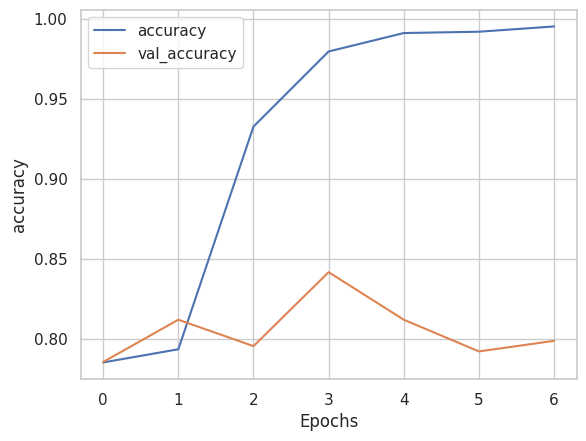

In [ ]:
# Plot the accuracy history
plot_graphs(history, 'accuracy')

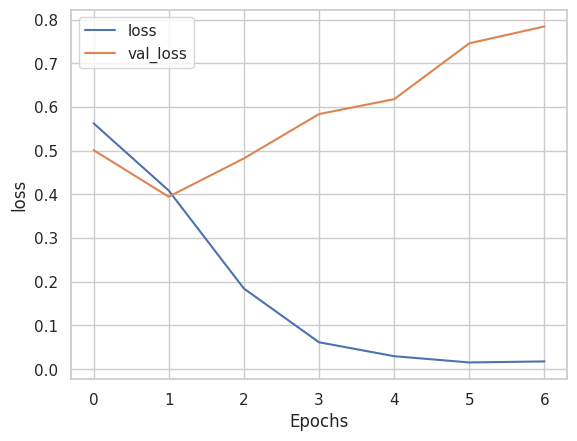

In [ ]:
# Plot the loss history
plot_graphs(history, 'loss')

## **Model Evaluation**

In [ ]:
predictions = text_model.predict(validation_padded)
predictions_classes = np.argmax(predictions,axis=1)
predictions_classes

10/10 [==============================] - 1s 6ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [90]:
from sklearn.metrics import classification_report,confusion_matrix

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

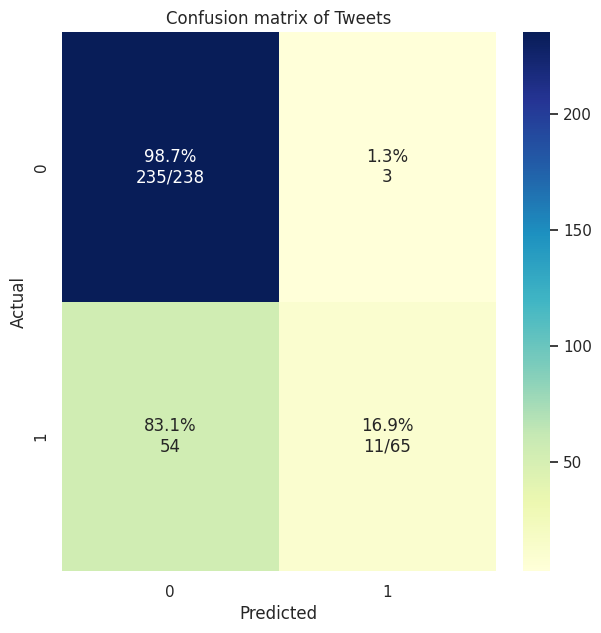

In [ ]:
# Showing Confusion Matrix
plot_cm(validation_labels,predictions_classes, 'Confusion matrix of Tweets', figsize=(7,7))

In [ ]:
print(classification_report(validation_labels, predictions_classes))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       238
           1       0.79      0.17      0.28        65

    accuracy                           0.81       303
   macro avg       0.80      0.58      0.59       303
weighted avg       0.81      0.81      0.76       303



# **Build and Compile Model (IndoBERT)**

In [27]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers

In [118]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [119]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [120]:
# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])

    return loss, list_hyp, list_label

## **Load Model**

In [33]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = 2

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [66]:
count_param(model)

124442882

## **Prepare Dataset**

In [121]:
training_data.head()

,id,text,label
0,1214939228112449541,suratsurat korban banjir,0
1,1213768866205093888,mari memenuhi panggilan kemanusiaan aksi solid...,0
2,1212325250014183424,jakarta banjir aniesbaswedan parcel kiriman ai...,0
3,1213463815314014209,simpen momen banjir kemarin aja memori hp penu...,0
4,1223403156157034496,ga kenal kenal lelah waktupastikan banjir suru...,0


In [122]:
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'is non-actionable': 0, 'is actionable': 1}
    INDEX2LABEL = {0: 'is non-actionable', 1: 'is actionable'}
    NUM_LABELS = 2

    def __init__(self, data, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = data
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, label = data['text'], data['label']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(label), data['text']

    def __len__(self):
        return len(self.data)

class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = label

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [123]:
train_dataset = DocumentSentimentDataset(training_data, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(validation_data, tokenizer, lowercase=True)
testing_dataset = DocumentSentimentDataset(testing_data, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=testing_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [124]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'is non-actionable': 0, 'is actionable': 1}
{0: 'is non-actionable', 1: 'is actionable'}


## **Fine Tuning**

In [125]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [126]:
# Train
n_epochs = 6
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

(Epoch 1) TRAIN LOSS:0.0179 LR:0.00000300: 100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


(Epoch 1) TRAIN LOSS:0.0179 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.7100 ACC:0.83 F1:0.75 REC:0.74 PRE:0.76: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


(Epoch 1) VALID LOSS:0.7100 ACC:0.83 F1:0.75 REC:0.74 PRE:0.76


(Epoch 2) TRAIN LOSS:0.0169 LR:0.00000300: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


(Epoch 2) TRAIN LOSS:0.0169 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.6612 ACC:0.83 F1:0.75 REC:0.75 PRE:0.75: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


(Epoch 2) VALID LOSS:0.6612 ACC:0.83 F1:0.75 REC:0.75 PRE:0.75


(Epoch 3) TRAIN LOSS:0.0162 LR:0.00000300: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


(Epoch 3) TRAIN LOSS:0.0162 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.6784 ACC:0.84 F1:0.76 REC:0.75 PRE:0.77: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


(Epoch 3) VALID LOSS:0.6784 ACC:0.84 F1:0.76 REC:0.75 PRE:0.77


(Epoch 4) TRAIN LOSS:0.0117 LR:0.00000300: 100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


(Epoch 4) TRAIN LOSS:0.0117 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.6882 ACC:0.84 F1:0.75 REC:0.74 PRE:0.76: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


(Epoch 4) VALID LOSS:0.6882 ACC:0.84 F1:0.75 REC:0.74 PRE:0.76


(Epoch 5) TRAIN LOSS:0.0101 LR:0.00000300: 100%|██████████| 38/38 [00:11<00:00,  3.17it/s]


(Epoch 5) TRAIN LOSS:0.0101 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.7376 ACC:0.84 F1:0.75 REC:0.74 PRE:0.77: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


(Epoch 5) VALID LOSS:0.7376 ACC:0.84 F1:0.75 REC:0.74 PRE:0.77


(Epoch 6) TRAIN LOSS:0.0106 LR:0.00000300: 100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


(Epoch 6) TRAIN LOSS:0.0106 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.7779 ACC:0.84 F1:0.73 REC:0.71 PRE:0.77: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]

(Epoch 6) VALID LOSS:0.7779 ACC:0.84 F1:0.73 REC:0.71 PRE:0.77


## **Evaluation**

In [127]:
def predict(text):
  subwords = tokenizer.encode(text)
  subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

  logits = model(subwords)[0]
  label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
  return label

predicted_label = []
true_label = []
for index, row in validation_data.iterrows():
  true_label.append(row['label'])
  predicted_label.append(predict(row['text']))

In [128]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(true_label, predicted_label))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       238
           1       0.67      0.48      0.56        65

    accuracy                           0.84       303
   macro avg       0.77      0.71      0.73       303
weighted avg       0.83      0.84      0.83       303



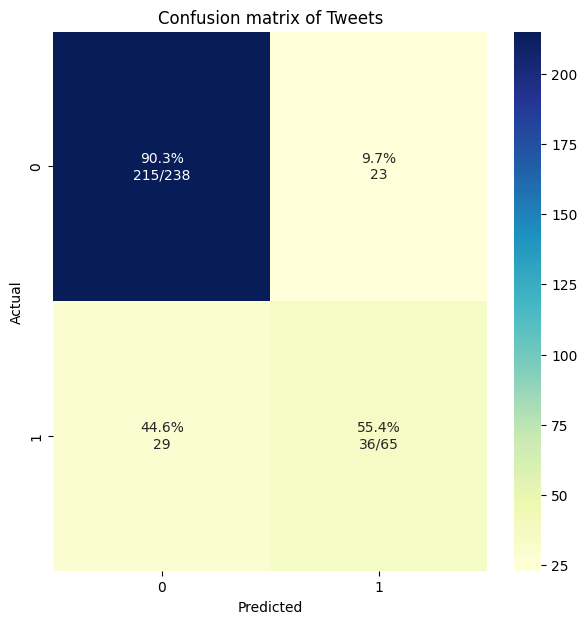

In [91]:
# Showing Confusion Matrix
plot_cm(true_label, predicted_label, 'Confusion matrix of Tweets', figsize=(7,7))

In [ ]:
testing_data['text'] = testing_data['text'].apply(lambda x: remove_urls(x))
testing_data['text'] = testing_data['text'].apply(lambda x: lower_casing(x))
testing_data['text'] = testing_data['text'].apply(lambda x: remove_punctuation(x))
testing_data['text'] = testing_data['text'].apply(lambda x: remove_extra_whitespaces(x))
testing_data['text'] = testing_data['text'].apply(lambda x: remove_stopwords(x))

In [135]:
text = testing_data['text'].iloc[122]
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: ka spk i aiptu tamyis anggota melaksanakan patroli kewilayahan antisipasi pemetaan bencana alam banjir tanah longsor tebing dsn krajan desa brongkol kelurahan jogowargojogonegoro | Label : is non-actionable (99.971%)


# **Data Testing**

## **Processing Text Data**

In [ ]:
testing_data['text'] = testing_data['text'].apply(lambda x: remove_urls(x))
testing_data['text'] = testing_data['text'].apply(lambda x: lower_casing(x))
testing_data['text'] = testing_data['text'].apply(lambda x: remove_punctuation(x))
testing_data['text'] = testing_data['text'].apply(lambda x: remove_extra_whitespaces(x))
testing_data['text'] = testing_data['text'].apply(lambda x: remove_stopwords(x))

In [137]:
testing_data['text'].iloc[0]

'giat pengangkutan sampah pasca banjir rw kelcakung timur keccakungsabtu januari aniesbaswedan herwansyah yogiikhwan dinaslhdki setiomargono ppdlksudinlhjaktim pasukanorangedlh dinaslhdki jktbebassampah gogreen welovejakarta bersihbisakok'

## **Predicting Data Testing**

In [139]:
predicted_label = []

for index, row in testing_data.iterrows():
  predicted_label.append(predict(row['text']))

## **Converting Result to DataFrame Submission**

In [140]:
result_df = pd.DataFrame({'id': testing_data['id'],
                       'label': predicted_label,
                       })

In [141]:
result_df

,id,label
0,1213309429254250496,0
1,1216196702647939072,0
2,1216296533735309312,0
3,1234385081482956800,0
4,1214853229567041537,0
...,...,...
1006,1212371781350084608,0
1007,1232075152042541056,1
1008,1213315563595845633,0
1009,1212970781610663936,1


In [142]:
result_df.label.value_counts()

0    810
1    201
Name: label, dtype: int64

In [ ]:
from google.colab import files
result_df.to_csv("final_submission_nlp.csv", index=False, header=True)
files.download('final_submission_nlp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>